# Attack the generative model
* Base attacks on the paper https://arxiv.org/pdf/1805.09190v3.pdf

Use attacks:
1. Gaussian Noise (random noise)
2. Salt and pepper noise (random noise)
3. Boundary Attack (non-gradient based)
4. Poinwise Attack (non-gradient based)
6. BIM/ Projected Gradient descent (gradient based)
7. FGSM (gradient based)
8. Latent Descent (novel attack for generative model)

How exactly to use these gradient based attacks?

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))
from utils.loading import load_net
from utils.display import torch_to_np, show_imgs
from models.generative_classify import optimize_latent_cvae, gen_classify_cvae, optimize_latent, gen_classify

from models.gen_classifiers import GenerativeCVAE, GenerativeVAE


import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torch.nn import functional as F
import torch.optim as optim

import foolbox
import json
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.current_device())

BASE_PATH = Path('/media/rene/data/adv_gen/MNIST/mnist_normal/models')

cuda:0
0


## First Make VAE classifier as a pytorch model

### Test the generative classifier as a pytorch model

In [3]:
files_df_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/files_df.pkl'
with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

img_path = files_df['val'].iloc[0]['path']
true_label = files_df['val'].iloc[0]['class']
transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
labels = list(range(10))
print('true_label: ', true_label)

true_label:  7.0


#### VAE

In [3]:
with torch.cuda.device(device.index):
    save_path = Path('/media/rene/data/adv_gen/MNIST/mnist_normal/models/VAE-1_16_32_64-16-MNIST/')
    model_dict = {}
    for label in labels:
        model_name = 'VAE-1_16_32_64-16-MNIST_label_'+str(label)+'_model_best.pth.tar'
        model_loc = save_path / model_name
        model_dict[label] = load_net(model_loc).to(device).eval()
    
    gen_model = GenerativeVAE(model_dict=model_dict, labels=labels, latent_size=16, device=device)
    pred_prob = gen_model(tensor_img, iterations=50, num_times=5).cpu().numpy()
    
    print('pred_prob:', pred_prob)
    pred = np.argmax(pred_prob)

print(f'predicted_label: {pred}, True Label: {true_label}')

pred_prob: [[4.3994346e-37 1.3101922e-19 0.0000000e+00 2.1056581e-09 1.8227510e-20
  1.4012985e-45 0.0000000e+00 1.0000000e+00 5.1885952e-12 3.7647245e-25]]
predicted_label: 7, True Label: 7.0


#### Conditional VAE Test

In [4]:
with torch.cuda.device(device.index):
    model_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/models/CVAE-1_16_32_64-16-MNIST-10_model_best.pth.tar'
    model = load_net(model_loc).to(device).eval()
    gen_model = GenerativeCVAE(model=model, labels=labels, latent_size=16, device=device)
    pred = np.argmax(gen_model(tensor_img, iterations=50, num_times=100).cpu().numpy())
        
print(f'predicted_label: {pred}, True Label: {label}')

NameError: name 'label' is not defined

## Simple attacks - Gaussian and Salt and Pepper Noise
* Add this noise to the imnage until is is misclassified.
* i.e. add noise to image until the loss of reconstruction is higher than the next highest class

In [7]:
result = pickle.load(open('/media/rene/data/adv_gen/MNIST/mnist_normal/models/results_ns6_gaussian_adv.pkl', "rb"))
display(result)

,attack_type,f_adv_pred,f_orig_pred,path,true_label
0,gaussian,6.0,4.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,4.0
1,gaussian,9.0,9.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,9.0
2,gaussian,7.0,7.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,7.0
3,gaussian,9.0,9.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,5.0
4,gaussian,8.0,8.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,3.0
5,gaussian,8.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,3.0


In [ ]:
with torch.cuda.device(device.index):
    save_path = Path('/media/rene/data/adv_gen/MNIST/mnist_normal/models/VAE_ABS/VAE_ABS--8-MNIST')
    labels = list(range(10))
    
    transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
    
    model_dict = {}
        model_file = Path(model_loc).name
        model_name = model_file.split('-')[0]
        for label in labels:
            model_file_cr = model_file + '_label_'+str(label)+'_model_best.pth.tar'
            model_loc_cr = str(model_loc.parent / model_file_cr)
            model_dict[label] = load_net(model_loc_cr).to(device).eval()
    
    gen_model = GenerativeVAE(model_dict=model_dict, labels=labels, latent_size=16, device=device)
        


    

In [7]:
result = pickle.load(open('/media/rene/data/adv_gen/MNIST/mnist_normal/models/VAE_ABS/results_ns20_gaussian_L0_adv.pkl', "rb"))
# display(result)
display(result[result['f_adv_pred']==result['true_label']])

print(result['adv_distance'].iloc[5].value)

print(result['path'].iloc[5])




,adv_distance,attack_type,distance,f_adv_pred,f_orig_pred,path,true_label
3,L0 distance = 0,gaussian,L0,9.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,9.0
5,L0 distance = 418,gaussian,L0,1.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,1.0
9,L0 distance = 0,gaussian,L0,0.0,2.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0
11,L0 distance = 0,gaussian,L0,6.0,6.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,6.0
12,L0 distance = 0,gaussian,L0,3.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,3.0
13,L0 distance = 0,gaussian,L0,3.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,3.0
15,L0 distance = 0,gaussian,L0,7.0,9.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,7.0
19,L0 distance = 428,gaussian,L0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0


418
/media/rene/data/adv_gen/MNIST/mnist_normal/val/val_5477.png


pred_prob: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4012985e-45
  1.4276773e-37 0.0000000e+00 0.0000000e+00 4.7966722e-34 1.0000000e+00]]
predicted_label: 9, True Label: 9.0


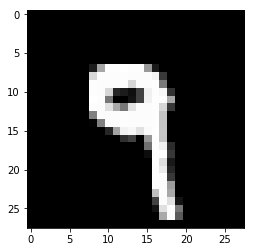

In [9]:
img_path = result['path'].iloc[3]
true_label = result['true_label'].iloc[3]
img = Image.open(img_path)
plt.imshow(img)

tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
pred_prob = gen_model(tensor_img, iterations=50, num_times=500).cpu().numpy()

print('pred_prob:', pred_prob)
print(f'predicted_label: {np.argmax(pred_prob)}, True Label: {true_label}')

In [4]:
result = pickle.load(open('/media/rene/data/adv_gen/MNIST/mnist_normal/models/VAE_ABS/results_ns20_gaussian_MSE_adv.pkl', "rb"))
display(result)

,adv_distance,attack_type,distance,f_adv_pred,f_orig_pred,path,true_label
0,normalized MSE = 1.63e-13,gaussian,MSE,3.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,3.0
1,normalized MSE = 0.00e+00,gaussian,MSE,8.0,5.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,5.0
2,normalized MSE = 1.85e-13,gaussian,MSE,1.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,1.0
3,normalized MSE = 4.62e-11,gaussian,MSE,7.0,9.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,7.0
4,normalized MSE = 0.00e+00,gaussian,MSE,5.0,6.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,5.0
5,normalized MSE = 1.34e-11,gaussian,MSE,1.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,1.0
6,normalized MSE = 1.84e-13,gaussian,MSE,8.0,9.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,8.0
7,normalized MSE = 0.00e+00,gaussian,MSE,7.0,9.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,7.0
8,normalized MSE = 0.00e+00,gaussian,MSE,7.0,7.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,7.0
9,normalized MSE = 0.00e+00,gaussian,MSE,1.0,2.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,8.0


In [3]:
from foolbox.attacks import AdditiveGaussianNoiseAttack
from models.gen_classifiers import GenerativeCVAE


num_workers = 0 ## ??? what?
batch_size = 1

num_classes = 10
labels = list(range(num_classes))

files_df_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/files_df.pkl'
with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

img_path = files_df['val'].iloc[4]['path']
transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
#                                 transforms.Normalize((0.1307,), (0.3081,))
                                ])
img = transform(Image.open(img_path)).unsqueeze(0).to(device)
label = files_df['val'].iloc[4]['class']

with torch.cuda.device(1):
    model_loc = '/media/rene/data/adv_gen/MNIST/mnist_normal/models/CVAE-1_16_32_64-16-MNIST-10_model_best.pth.tar'
    model = load_net(model_loc).to(device).eval()
    gen_model = GenerativeCVAE(model=model, labels=labels, latent_size=16, device=device).eval()
    predicted_label = gen_model(img, iterations=50, num_times=100, info=False)
    print('predicted_label', predicted_label)

RuntimeError: input and target shapes do not match: input [1 x 32 x 32], target [1 x 1 x 32 x 32] at /pytorch/aten/src/THCUNN/generic/MSECriterion.cu:12

In [5]:
from models.cifar import PreActResNet
from utils.loading import load_net_cifar
model_loc = '/media/rene/data/adv_consistency/MNIST/models/preact_resnet-18_model_best.pth.tar'
model = load_net_cifar(model_loc)

with torch.cuda.device(1):
    mean = np.array([0.1307]).reshape((1, 1, 1))
    std = np.array([0.3081]).reshape((1, 1, 1))
    
    fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), preprocessing=(.1307, .3081), 
                                         num_classes=num_classes, device=device)
    attack = foolbox.attacks.AdditiveGaussianNoiseAttack(fmodel)
    
    print('img.size()', img.size())
    print('torch.min(img)', torch.min(img))
    print('torch.max(img)', torch.max(img))
    print('type(label)', type(label))
    print('label', label)

    np_img = np.expand_dims(np.squeeze(img.cpu().numpy()), 0) #/ 255.
#     np_img = np.squeeze(img.cpu().numpy())#/ 255.



    np_label = int(label)#int(label.numpy()[0])
    print('np_img.shape', np_img.shape)
    print('np.min(np_img)', np.min(np_img))
    print('np.max(np_img)', np.max(np_img))
    print('np_label', np_label)

    adv_img = attack(np_img, np_label)

Loading model_file preact_resnet-18_model_best.pth.tar
img.size() torch.Size([1, 1, 32, 32])
torch.min(img) tensor(0., device='cuda:1')
torch.max(img) tensor(0.9922, device='cuda:1')
type(label) <class 'numpy.float64'>
label 4.0
np_img.shape (1, 32, 32)
np.min(np_img) 0.0
np.max(np_img) 0.99215686
np_label 4


/media/rene/ADV/lib/python3.6/site-packages/foolbox/models/pytorch.py:60: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  'The PyTorch model is in training mode and therefore might'


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 32, 32] to have 3 channels, but got 1 channels instead

In [2]:
result = pickle.load(open('/media/rene/data/adv_gen/MNIST/mnist_normal/models/results_ns10_pointwise_adv.pkl', "rb"))
display(result)

,adv_pred,attack_type,f_adv_pred,f_pred,orig_pred,path,trans_orig_pred,true_label
0,0.0,pointwise,6.0,2.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,9.0
1,0.0,pointwise,2.0,0.0,2.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,1.0,8.0
2,6.0,pointwise,0.0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,8.0
3,2.0,pointwise,2.0,2.0,2.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,1.0,0.0
4,2.0,pointwise,4.0,4.0,4.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,1.0,0.0
5,3.0,pointwise,3.0,2.0,2.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,3.0,5.0
6,0.0,pointwise,0.0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,1.0
7,0.0,pointwise,0.0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,6.0,9.0
8,0.0,pointwise,0.0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,9.0
9,0.0,pointwise,0.0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,1.0


In [3]:
result = pickle.load(open('/media/rene/data/adv_gen/MNIST/mnist_normal/models/results_ns6_saltpepper_adv.pkl', "rb"))
display(result)

,adv_pred,attack_type,f_adv_pred,f_pred,orig_pred,path,trans_orig_pred,true_label
0,0.0,saltpepper,0.0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,0.0
1,5.0,saltpepper,5.0,1.0,5.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,5.0
2,3.0,saltpepper,3.0,3.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,3.0,3.0
3,2.0,saltpepper,1.0,0.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,2.0,6.0
4,1.0,saltpepper,1.0,1.0,1.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,1.0,2.0
5,0.0,saltpepper,0.0,0.0,0.0,/media/rene/data/adv_gen/MNIST/mnist_normal/va...,0.0,0.0


In [6]:
import sys
print(sys.version)
print(sys.path)

3.6.3 |Anaconda, Inc.| (default, Nov 20 2017, 20:41:42) 
[GCC 7.2.0]
['', '/media/rene/code/adv-gen/notebooks', '/media/rene/Data/fastai', '/home/rene/miniconda3/lib/python36.zip', '/home/rene/miniconda3/lib/python3.6', '/home/rene/miniconda3/lib/python3.6/lib-dynload', '/media/rene/ADV/lib/python3.6/site-packages', '/media/rene/ADV/lib/python3.6/site-packages/IPython/extensions', '/home/rene/.ipython', '/media/rene/code/adv-gen', '/media/rene/code/adv-gen']


In [ ]:
num_workers = 0 ## ??? what?
batch_size = 1

num_classes = 10
labels = list(range(num_classes))

with open(args.files_df_loc, 'rb') as f:
    files_df = pickle.load(f)
files_df['val'] = files_df['val'].sample(n=sample_num)

# Make generators:
if args.dataset == 'CIFAR10':
    dataloaders = make_generators_DF_cifar(files_df, batch_size, num_workers, size=IM_SIZE, 
                                            path_colname='path', adv_path_colname=None, return_loc=True)
elif args.dataset == 'MNIST':
    dataloaders = make_generators_DF_MNIST(files_df, batch_size, num_workers, size=IM_SIZE,
                                            path_colname='path', adv_path_colname=None, return_loc=True, normalize=False)

model = load_net(model_loc).to(device).eval()
gen_model = GenerativeCVAE(model=model, labels=labels, latent_size=16, device=device).eval()
fmodel = foolbox.models.PyTorchModel(gen_model, bounds=(0, 1), num_classes=num_classes, device=device) # no preprocessing since using data loader
attack  = get_attack(attack_type, fmodel)


for i, batch in enumerate(tqdm(dataloaders['val'])):
    problem_examples = 0
    img, label, file_loc = batch[0], batch[1], batch[2][0]

    # image, label, file_loc = batch[0].numpy(), int(batch[1].numpy()), batch[2][0]
    # image = load_image(file_loc) See if should use this with the foolbox preprocessign instead
    # np_img = np.expand_dims(np.squeeze(img.numpy()), 0)

    np_img = np.squeeze(img.numpy())
    np_label = int(label.numpy()[0])
    print('np_img.shape', np_img.shape)
    print('np_label', np_label)

    print('img.size()', img.size())
    print('torch.min(img)', torch.min(img))
    print('torch.max(img)', torch.max(img))


    adv_img = attack(np_img, np_label)

    attack = foolbox.attacks.AdditiveGaussianNoiseAttack(fmodel)
    adv_img = attack(img, label)


    print('type(adv_img)', type(adv_img))
    print('adv_img.shape', adv_img.shape)
    print('np.min(adv_img)', np.min(adv_img))
    print('np.max(adv_img)', np.max(adv_img))


    orig_pred = model(img)
    adv_pred = model(adv_img)

## Latent Descent Attack